# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports-and-Settings" data-toc-modified-id="Imports-and-Settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Settings</a></div><div class="lev1 toc-item"><a href="#Preparing-Data" data-toc-modified-id="Preparing-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing Data</a></div><div class="lev2 toc-item"><a href="#Split-the-data-into-training-and-test-sets" data-toc-modified-id="Split-the-data-into-training-and-test-sets-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split the data into training and test sets</a></div><div class="lev2 toc-item"><a href="#Define-PL/Python-Functions" data-toc-modified-id="Define-PL/Python-Functions-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Define PL/Python Functions</a></div><div class="lev1 toc-item"><a href="#Test-Set-on-Batches" data-toc-modified-id="Test-Set-on-Batches-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test Set on Batches</a></div><div class="lev1 toc-item"><a href="#Check-Performance" data-toc-modified-id="Check-Performance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check Performance</a></div>

# Imports and Settings

Import relevant Python libraries.

In [1]:
from IPython.display import display, HTML
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sqlalchemy import create_engine

import credentials

In [2]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
sns.set_palette('colorblind')
blue, green, red, purple, yellow, cyan = sns.color_palette('colorblind')

Connect to the database.

In [3]:
conn = psycopg2.connect(**credentials.gpdb_login_dict)
conn.autocommit = True

# Preparing Data

We would like to drop all rows with null values. We do that by writing a where clause that checks that each column is not null.

In [4]:
sql = '''
SELECT column_name
  FROM information_schema.columns
 WHERE table_name = 'credit_scores'
 ORDER BY ordinal_position;
'''
col_names_df = psql.read_sql(sql, conn)

In [5]:
count_cols = ', '.join(["COUNT({0}) AS count_{0}".format(i)
                            for i in col_names_df.column_name])
not_null_clause = ' AND '.join(['{} IS NOT NULL'.format(i)
                                    for i in col_names_df.column_name])

In [6]:
sql = '''
DROP TABLE IF EXISTS credit_scores_dropna;
CREATE TABLE credit_scores_dropna
   AS SELECT row_number()
                 OVER (PARTITION BY serious_dlq_in_2_yrs
                           ORDER BY random()
                      ) AS id,
             *
        FROM credit_scores
       WHERE {not_null_clause}
 DISTRIBUTED BY (id);
'''
print sql
psql.execute(sql.format(**globals()), conn)


DROP TABLE IF EXISTS credit_scores_dropna;
CREATE TABLE credit_scores_dropna
   AS SELECT row_number()
                 OVER (PARTITION BY serious_dlq_in_2_yrs
                           ORDER BY random()
                      ) AS id,
             *
        FROM credit_scores
       WHERE {not_null_clause}
 DISTRIBUTED BY (id);



<cursor object at 0x11054d650; closed: 0>

## Split the data into training and test sets

Get the number of labels in each class.

In [7]:
sql = '''
SELECT serious_dlq_in_2_yrs, COUNT(*)
  FROM credit_scores_dropna
 GROUP BY serious_dlq_in_2_yrs
 ORDER BY serious_dlq_in_2_yrs;
'''
psql.read_sql(sql, conn)

,serious_dlq_in_2_yrs,count
0,0,111912
1,1,8357


Since the proportion of the labels is not equal, we have a class imbalance problem. Training on a data set that has the same proportions as the actual data set will bias the model to prefer non-deliquent accounts. We will instead split up our data so that the training set has equal proportions of both classes.

In [8]:
sql = '''
DROP TABLE IF EXISTS credit_scores_train;
CREATE TABLE credit_scores_train
   AS SELECT row_number() OVER () AS row_id, *
        FROM credit_scores_dropna
       WHERE id < 8357 * 0.8
 DISTRIBUTED BY (id);
 
DROP TABLE IF EXISTS credit_scores_test;
CREATE TABLE credit_scores_test
   AS SELECT row_number() OVER () AS row_id, *
        FROM credit_scores_dropna
       WHERE id >= 8357 * 0.8
 DISTRIBUTED BY (id);
'''
psql.execute(sql, conn)

<cursor object at 0x11054d550; closed: 0>

To verify this, we check the number of each class in both the training and test sets.

In [9]:
sql = '''
SELECT serious_dlq_in_2_yrs, COUNT(*)
  FROM credit_scores_train
 GROUP BY serious_dlq_in_2_yrs
 ORDER BY serious_dlq_in_2_yrs;
'''
display(psql.read_sql(sql, conn))

sql = '''
SELECT serious_dlq_in_2_yrs, COUNT(*)
  FROM credit_scores_test
 GROUP BY serious_dlq_in_2_yrs
 ORDER BY serious_dlq_in_2_yrs;
'''
display(psql.read_sql(sql, conn))

,serious_dlq_in_2_yrs,count
0,0,6685
1,1,6685


,serious_dlq_in_2_yrs,count
0,0,105227
1,1,1672


## Define PL/Python Functions
We define two PL/Python functions:
- One will train our model given input data. It will output a <a href='https://docs.python.org/2/library/pickle.html'>pickled</a> model object.
- The second PL/Python function will read in the pickled model object and apply the model to test data.

In [10]:
sql = '''
DROP FUNCTION IF EXISTS run_random_forest_clf(INTEGER[],
                                              DOUBLE PRECISION[],
                                              INTEGER,
                                              INTEGER
                                             );
-- Creates a PL/Python UDF to train a random forests. It outputs the
-- pickled random forest object.
CREATE FUNCTION run_random_forest_clf(y_var INTEGER[],
                                      x_matrix DOUBLE PRECISION[],
                                      num_features INTEGER,
                                      max_depth INTEGER
                                     )
RETURNS BYTEA
AS
$$
    import cPickle

    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    
    X = np.array(x_matrix).reshape(-1, num_features)
    
    rf_clf = RandomForestClassifier(max_depth=max_depth,
                                    n_estimators=10,
                                    n_jobs=-1
                                   )
    rf_clf.fit(X, y_var)
    
    pckl = cPickle.dumps(rf_clf)
    
    return pckl
$$
LANGUAGE plpythonu;

DROP FUNCTION IF EXISTS predict_random_forest(BYTEA,
                                              DOUBLE PRECISION[],
                                              INTEGER
                                             );
-- Creates a PL/Python UDF to predict based off the trained random
-- forest. It outputs the predicted probability.
CREATE FUNCTION predict_random_forest(pckl BYTEA,
                                      x_matrix DOUBLE PRECISION[],
                                      num_features INTEGER
                                     )
RETURNS DOUBLE PRECISION[]
AS
$$
    import cPickle
    
    import numpy as np
        
    X = np.array(x_matrix).reshape(-1, num_features)
    rf_clf = cPickle.loads(pckl)
    
    return rf_clf.predict_proba(X)[:, 1]
$$
LANGUAGE plpythonu;
'''
psql.execute(sql, conn)

<cursor object at 0x11054d750; closed: 0>

The next query creates a custom aggregate function. In the PostgreSQL standard, performing an <a href='https://www.postgresql.org/docs/9.5/static/functions-aggregate.html'>`array_agg`</a> on array types does not work, so we need to create our own. This allows the entire training set to be collapsed into a single array so we can feed it into a PL/Python function.

In [11]:
# Creates an aggregate function that allows us to do array_agg on an
# array.
sql = '''
DROP AGGREGATE IF EXISTS array_agg_array(anyarray);
CREATE ORDERED AGGREGATE array_agg_array(anyarray)
(
    SFUNC = array_cat,
    STYPE = anyarray
);
'''
psql.execute(sql, conn)

<cursor object at 0x11054d850; closed: 0>

We run our random forest by using our new aggregate `array_agg_array` to fit all of the data into a single cell. We also cross join the training set with a set of different parameters across 10 iterations. By stating

    DISTRIBUTED BY (max_depth, iter_num)
   
, it allows us to run each combination of `max_depth` and `iter_num` in parallel.

In [12]:
X_names = list(col_names_df.column_name)
X_names.remove('serious_dlq_in_2_yrs')

# Run Random Forest
sql = '''
DROP TABLE IF EXISTS random_forest_pckl;
CREATE TABLE random_forest_pckl
   AS SELECT iter_num,
             max_depth,
             run_random_forest_clf(array_agg(serious_dlq_in_2_yrs),
                                   array_agg_array(ARRAY[{}]),
                                   {},
                                   max_depth
                                  ) AS pckl
        FROM credit_scores_train
             CROSS JOIN (SELECT generate_series(1, 10) AS max_depth) AS params
             CROSS JOIN (SELECT generate_series(1, 10) AS iter_num) AS iterations
       GROUP BY max_depth, iter_num
 DISTRIBUTED BY (max_depth, iter_num);
'''.format(', '.join(X_names), len(X_names))
print sql
psql.execute(sql, conn)


DROP TABLE IF EXISTS random_forest_pckl;
CREATE TABLE random_forest_pckl
   AS SELECT iter_num,
             max_depth,
             run_random_forest_clf(array_agg(serious_dlq_in_2_yrs),
                                   array_agg_array(ARRAY[revolving_util_unsecured_lines, age, num_time_30_59_days_past_due_not_worse, debt_ratio, monthly_income, num_open_credit_line_loans, num_time_90_days_late, num_real_estate_loan_lines, num_time_60_89_days_past_due_not_worse, num_dependents]),
                                   10,
                                   max_depth
                                  ) AS pckl
        FROM credit_scores_train
             CROSS JOIN (SELECT generate_series(1, 10) AS max_depth) AS params
             CROSS JOIN (SELECT generate_series(1, 10) AS iter_num) AS iterations
       GROUP BY max_depth, iter_num
 DISTRIBUTED BY (max_depth, iter_num);



<cursor object at 0x11054d950; closed: 0>

# Test Set on Batches

Now that we have trained the model, we must apply it to the entire data set. Since the test set is much larger than the training set, it behooves us to not `array_agg_array` the entire test set. Otherwise, all of it will be read into a single PL/Python instance. We can instead split the test set into batches so that each PL/Python instance can run in parallel and so they each have a smaller load.

In [13]:
sql = '''
DROP TABLE IF EXISTS random_forest_pred_batch;
CREATE TABLE random_forest_pred_batch
   AS SELECT max_depth,
             iter_num,
             predict_random_forest(pckl,
                                   feature_array,
                                   {}
                                  ) AS score,
             row_id_array
        FROM (SELECT row_id/2000 AS batch_num,
                     array_agg_array(ARRAY[{}] ORDER BY row_id) AS feature_array,
                     array_agg(row_id ORDER BY row_id) AS row_id_array
                FROM credit_scores_test
               GROUP BY batch_num
             ) AS f
             CROSS JOIN random_forest_pckl
 DISTRIBUTED BY (max_depth, iter_num);
'''.format(len(X_names),
           ', '.join(X_names))
print sql
psql.execute(sql, conn)


DROP TABLE IF EXISTS random_forest_pred_batch;
CREATE TABLE random_forest_pred_batch
   AS SELECT max_depth,
             iter_num,
             predict_random_forest(pckl,
                                   feature_array,
                                   10
                                  ) AS score,
             row_id_array
        FROM (SELECT row_id/2000 AS batch_num,
                     array_agg_array(ARRAY[revolving_util_unsecured_lines, age, num_time_30_59_days_past_due_not_worse, debt_ratio, monthly_income, num_open_credit_line_loans, num_time_90_days_late, num_real_estate_loan_lines, num_time_60_89_days_past_due_not_worse, num_dependents] ORDER BY row_id) AS feature_array,
                     array_agg(row_id ORDER BY row_id) AS row_id_array
                FROM credit_scores_test
               GROUP BY batch_num
             ) AS f
             CROSS JOIN random_forest_pckl
 DISTRIBUTED BY (max_depth, iter_num);



<cursor object at 0x11054da50; closed: 0>

Our final step is `UNNEST` our predicted scores and match them up with our test data.

In [14]:
sql = '''
DROP TABLE IF EXISTS random_forest_pred_score_batch;
CREATE TABLE random_forest_pred_score_batch
     AS WITH temp_scores AS
             (SELECT max_depth,
                     iter_num,
                     UNNEST(score) AS score,
                     UNNEST(row_id_array) AS row_id
                FROM random_forest_pred_batch
             ),
             temp_credit_scores AS
             (SELECT * FROM credit_scores_test)
      SELECT row_id,
             max_depth,
             iter_num,
             score,
             serious_dlq_in_2_yrs
        FROM temp_scores
             INNER JOIN temp_credit_scores
                  USING (row_id)
 DISTRIBUTED BY (row_id);
'''
psql.execute(sql, conn)

<cursor object at 0x11054db50; closed: 0>

# Check Performance

We can now verify how well our model performed at varying levels of `max_depth`.

In [15]:
sql = '''
SELECT max_depth,
       serious_dlq_in_2_yrs AS y_true,
       score AS y_score, *
  FROM random_forest_pred_score_batch;
'''
score_label_df = psql.read_sql(sql, conn)

In [16]:
# Gather all of the AUCs
auc_list = []
max_depth_list = []
for max_depth in xrange(1, 11):
    for iter_num in xrange(1, 11):
        _temp_df = score_label_df.query('max_depth == {} & iter_num == {}'
                                            .format(max_depth, iter_num))
        auc_list.append(roc_auc_score(_temp_df.y_true,
                                      _temp_df.y_score))
        max_depth_list.append(max_depth)

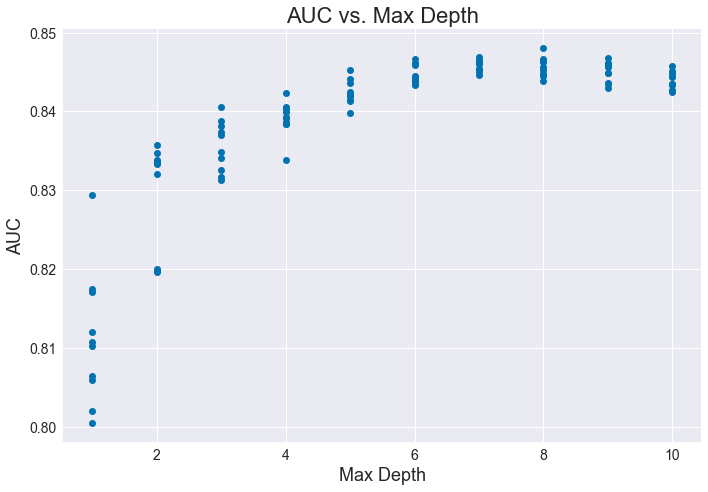

In [17]:
plt.plot(max_depth_list, auc_list, 'o')
plt.title('AUC vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('AUC')
plt.tight_layout()

plt.savefig('auc_vs_max_depth.png')